In [36]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_text
from sklearn.metrics import roc_auc_score

from sklearn.ensemble import RandomForestRegressor

In [2]:
df = pd.read_csv('housing.csv')

In [3]:
df = df[(df['ocean_proximity'] == '<1H OCEAN') | (df['ocean_proximity'] == 'INLAND')].reset_index(drop=True)

In [4]:
df['total_bedrooms'] = df['total_bedrooms'].fillna(0)

In [5]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

In [6]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)



In [7]:
y_train = np.log1p(df_train.median_house_value)
y_val = np.log1p(df_val.median_house_value)
y_test = np.log1p(df_test.median_house_value)

In [8]:
del df_train['median_house_value']
del df_val['median_house_value']
del df_test['median_house_value']


In [58]:
dv = DictVectorizer()
X_train = dv.fit_transform(df_train.to_dict(orient="records"))
X_val = dv.transform(df_val.to_dict(orient="records"))
X_test = dv.transform(df_test.to_dict(orient="records"))

In [10]:
dt = DecisionTreeRegressor(max_depth=1)
dt.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=1)

In [11]:
print(export_text(dt, feature_names=list(dv.get_feature_names_out())))

|--- ocean_proximity=<1H OCEAN <= 0.50
|   |--- value: [11.61]
|--- ocean_proximity=<1H OCEAN >  0.50
|   |--- value: [12.30]



In [12]:
rf = RandomForestRegressor(n_estimators=10, random_state=1, n_jobs=-1)
rf.fit(X_train, y_train)

RandomForestRegressor(n_estimators=10, n_jobs=-1, random_state=1)

In [13]:
def rmse(y, y_pred):
    error = y - y_pred
    se = error ** 2
    mse = se.mean()
    return np.sqrt(mse)

In [14]:
y_pred = rf.predict(X_val)
rmse(y_val,y_pred)


0.24527740463893766

In [15]:
scores = []

for n in range(10, 201, 10):
        rf = RandomForestRegressor(n_estimators=n, n_jobs=-1, random_state=1)
        rf.fit(X_train, y_train)

        y_pred = rf.predict(X_val)
        r = rmse(y_val,y_pred)
        print (f'{n}: {r}')
        scores.append((n, r))

10: 0.24527740463893777
20: 0.2390406168651719
30: 0.23699502678947681
40: 0.23550884330709165
50: 0.23516229825028961
60: 0.23471089539815948
70: 0.2345736335549424
80: 0.2348154203466172
90: 0.23459303795867223
100: 0.23441467733853819
110: 0.2344021823772726
120: 0.2342219763649724
130: 0.23402331915715463
140: 0.2337738039973723
150: 0.23369489874504734
160: 0.23353412957567454
170: 0.23346792386040713
180: 0.2336167257146944
190: 0.233855071973486
200: 0.23376164617188594


In [16]:
columns = ['n_estimators', 'rmse']
df_scores = pd.DataFrame(scores, columns=columns)

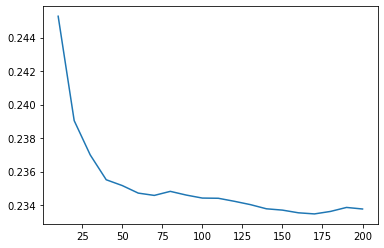

In [17]:
plt.plot(df_scores.n_estimators, df_scores.rmse)

In [18]:
scores = []

for s in [10, 15, 20, 25]:
    for n in range(10, 201, 10):
        rf = RandomForestRegressor(n_estimators=n,
                                    max_depth=s,
                                    n_jobs=-1,
                                    random_state=1)
        
        rf.fit(X_train, y_train)

        y_pred = rf.predict(X_val)
        r = rmse(y_val, y_pred)
        print (f'{s}-{n}: {r}')
        scores.append((s, n, r))

10-10: 0.25067714286967
10-20: 0.2476719287300438
10-30: 0.24643411411803698
10-40: 0.2451678037310995
10-50: 0.24555736366386027
10-60: 0.24535165259564834
10-70: 0.24540770334945547
10-80: 0.2456400767862735
10-90: 0.24553597121885168
10-100: 0.24544642000029065
10-110: 0.245343705537584
10-120: 0.24512513704735345
10-130: 0.24485654120695846
10-140: 0.24463462871781044
10-150: 0.24459315934955658
10-160: 0.24450136088985563
10-170: 0.24446036538559973
10-180: 0.24456882266496313
10-190: 0.24477143849125335
10-200: 0.244773021210925
15-10: 0.24577217152575948
15-20: 0.23958260550158159
15-30: 0.2377294205231006
15-40: 0.23594829581796609
15-50: 0.23604632017701238
15-60: 0.23573059928218384
15-70: 0.23552212716061466
15-80: 0.2357282480746409
15-90: 0.23543701795941605
15-100: 0.23535585187215569
15-110: 0.23515522588984947
15-120: 0.23495307645928776
15-130: 0.23481957036069118
15-140: 0.23460949259472663
15-150: 0.23450197986667734
15-160: 0.2343025556189478
15-170: 0.2342946183182

In [19]:
columns = ['max_depth', 'n_estimators', 'rmse']
df_scores = pd.DataFrame(scores, columns=columns)

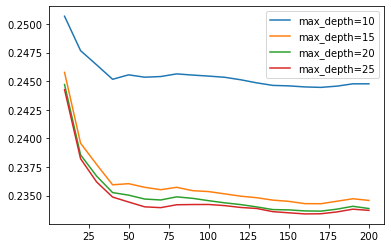

In [20]:
for d in [10, 15, 20, 25]:
    df_subset = df_scores[df_scores.max_depth == d]
    
    plt.plot(df_subset.n_estimators, df_subset.rmse,
             label='max_depth=%d' % d)

plt.legend()

In [30]:
rf = RandomForestRegressor(n_estimators=10, max_depth=20, n_jobs=-1, random_state=1)
rf.fit(X_train, y_train)
rf.feature_importances_

array([0.0151361 , 0.03031726, 0.10200703, 0.08624381, 0.33561113,
       0.29247297, 0.07380644, 0.02713606, 0.01585222, 0.02141699])

TypeError: set_theme() got an unexpected keyword argument 'width'

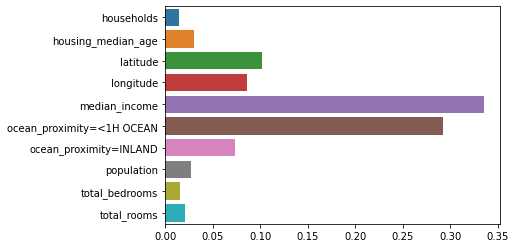

In [53]:
df_feat_import = pd.Series(data=rf.feature_importances_, index=dv.feature_names_)
sns.barplot(y=df_feat_import.index, x=df_feat_import)
sns.set(width=12);


In [46]:
!pip install xgboost

^C


In [47]:
import xgboost as xgb

In [103]:
df_train.ocean_proximity = df_train.ocean_proximity.str.replace("<", "").str.replace(" ", "_").str.lower()
dv = DictVectorizer()
X_train = dv.fit_transform(df_train.to_dict(orient="records"))

features = dv.get_feature_names()
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

watchlist = [(dtrain, 'train'), (dval, 'val')]


c:\Users\Ebenezer\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [107]:
xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=100, evals=watchlist)

[0]	train-rmse:0.44350	val-rmse:0.44250
[1]	train-rmse:0.36599	val-rmse:0.36916
[2]	train-rmse:0.31556	val-rmse:0.32382
[3]	train-rmse:0.28541	val-rmse:0.29965
[4]	train-rmse:0.26573	val-rmse:0.28417
[5]	train-rmse:0.25338	val-rmse:0.27463
[6]	train-rmse:0.24157	val-rmse:0.26770
[7]	train-rmse:0.23486	val-rmse:0.26423
[8]	train-rmse:0.22668	val-rmse:0.25820
[9]	train-rmse:0.21995	val-rmse:0.25444
[10]	train-rmse:0.21444	val-rmse:0.25179
[11]	train-rmse:0.21155	val-rmse:0.25054
[12]	train-rmse:0.20729	val-rmse:0.24791
[13]	train-rmse:0.20317	val-rmse:0.24628
[14]	train-rmse:0.20135	val-rmse:0.24630
[15]	train-rmse:0.19858	val-rmse:0.24522
[16]	train-rmse:0.19580	val-rmse:0.24445
[17]	train-rmse:0.19333	val-rmse:0.24395
[18]	train-rmse:0.19107	val-rmse:0.24284
[19]	train-rmse:0.18735	val-rmse:0.24127
[20]	train-rmse:0.18524	val-rmse:0.23978
[21]	train-rmse:0.18332	val-rmse:0.23963
[22]	train-rmse:0.18189	val-rmse:0.23892
[23]	train-rmse:0.18006	val-rmse:0.23847
[24]	train-rmse:0.17869	va

In [108]:
y_pred = model.predict(dval)

In [109]:
rmse(y_val, y_pred)

0.2286231999801062

In [110]:
xgb_params = {
    'eta': 0.1, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=100, evals=watchlist)

[0]	train-rmse:0.52449	val-rmse:0.52045
[1]	train-rmse:0.48736	val-rmse:0.48443
[2]	train-rmse:0.45433	val-rmse:0.45293
[3]	train-rmse:0.42533	val-rmse:0.42550
[4]	train-rmse:0.39987	val-rmse:0.40144
[5]	train-rmse:0.37822	val-rmse:0.38151
[6]	train-rmse:0.35887	val-rmse:0.36393
[7]	train-rmse:0.34177	val-rmse:0.34838
[8]	train-rmse:0.32701	val-rmse:0.33492
[9]	train-rmse:0.31411	val-rmse:0.32333
[10]	train-rmse:0.30326	val-rmse:0.31427
[11]	train-rmse:0.29355	val-rmse:0.30615
[12]	train-rmse:0.28519	val-rmse:0.29922
[13]	train-rmse:0.27760	val-rmse:0.29269
[14]	train-rmse:0.27116	val-rmse:0.28796
[15]	train-rmse:0.26538	val-rmse:0.28380
[16]	train-rmse:0.26012	val-rmse:0.27970
[17]	train-rmse:0.25583	val-rmse:0.27661
[18]	train-rmse:0.25203	val-rmse:0.27388
[19]	train-rmse:0.24818	val-rmse:0.27123
[20]	train-rmse:0.24512	val-rmse:0.26882
[21]	train-rmse:0.24149	val-rmse:0.26669
[22]	train-rmse:0.23895	val-rmse:0.26478
[23]	train-rmse:0.23594	val-rmse:0.26331
[24]	train-rmse:0.23305	va

In [111]:
y_pred = model.predict(dval)

In [112]:
rmse(y_val, y_pred)

0.23208927121609324